# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np

import pandas as pd
import numpy as np
import seaborn as sns
import math

from scipy import stats as st
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import  make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import make_scorer, mean_absolute_error, accuracy_score, f1_score, recall_score, precision_score, roc_auc_score,roc_curve, confusion_matrix

import warnings
warnings.filterwarnings('ignore')
from IPython.display import display

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


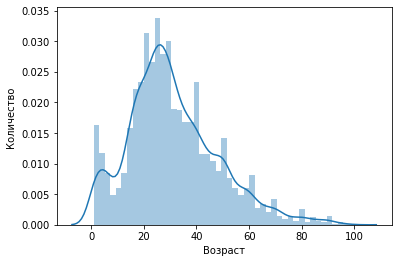

In [5]:
sns.distplot(labels['real_age'], label='real_age')

plt.xlabel('Возраст')
plt.ylabel('Количество ')
plt.show()

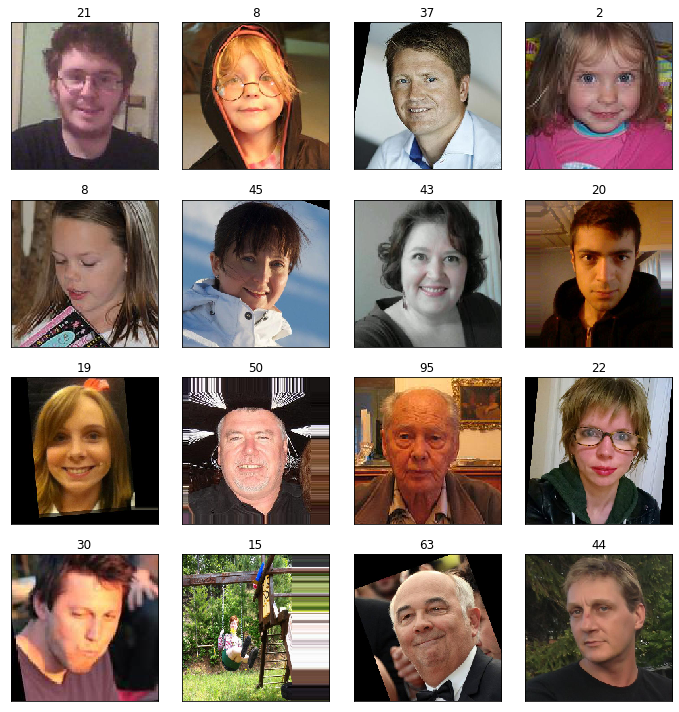

In [11]:
features, target = next(train_gen_flow)

# выводим 16 изображений
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(target[i])
    plt.tight_layout()
    
    

В выборке 7591 фотография, возраст от 1 до 100 лет, средний возраст 31, медиана на 29 годах, больше всего фото от 20 до 41 года, на фото присутствуют объекты, которые буду плохо влиять на обучение(жвачка, головные уборы, перекрывание рукой лица, нечеткие фото)

- Выборка средняя, для улучшения качества будем использовать аугментацию отражение , будем использовать архитиктуру ResNet50
-  возраст от 1 до 100 лет, средний возраст 31, медиана на 29 годах, больше всего фото от 20 до 41 года, имеются пики на в юбилеях 6 думаю это сделанно сознательно при подборе выборки, для четкого представления разделения по десятилетиям
- качесво фото оставляет желать лучшего, присутствуют фото где лица не видно совсем, на фото уже есть повороты угол примерно 20", фото цветные, также на некоторых фото присутствуют постороние предметы закрывающие лицо

## Обучение модели

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
```

```

Train for 356 steps, validate for 119 steps
Epoch 1/10
2021-11-09 14:11:31.300728: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-11-09 14:11:35.043379: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 143s - loss: 210.5706 - mae: 10.5439 - val_loss: 569.9133 - val_mae: 18.8007
Epoch 2/10
356/356 - 43s - loss: 83.6992 - mae: 6.9341 - val_loss: 128.4976 - val_mae: 8.3946
Epoch 3/10
356/356 - 43s - loss: 56.7391 - mae: 5.7489 - val_loss: 80.7536 - val_mae: 6.6868
Epoch 4/10
356/356 - 42s - loss: 43.0465 - mae: 5.0276 - val_loss: 87.4974 - val_mae: 6.8869
Epoch 5/10
356/356 - 42s - loss: 32.8622 - mae: 4.3458 - val_loss: 74.6037 - val_mae: 6.5498
Epoch 6/10
356/356 - 42s - loss: 24.4559 - mae: 3.7624 - val_loss: 80.4914 - val_mae: 6.7735
Epoch 7/10
356/356 - 42s - loss: 19.7974 - mae: 3.4110 - val_loss: 75.5650 - val_mae: 6.4720
Epoch 8/10
356/356 - 41s - loss: 15.7855 - mae: 3.0225 - val_loss: 68.0404 - val_mae: 6.1762
Epoch 9/10
356/356 - 41s - loss: 14.1233 - mae: 2.8878 - val_loss: 64.3760 - val_mae: 5.9283
Epoch 10/10
356/356 - 41s - loss: 12.5944 - mae: 2.6846 - val_loss: 70.9052 - val_mae: 6.1638


Модель сверточной нейронной сети построена на ResNet50.
За 10 эпох обучения удалось уменьшить MAE с 10 до 2.6 на тренировочной выборке. Дальнейшее обучение возможно улучшит результат.


## Анализ обученной модели

Обученная модель позволяет с высокой точностью предсказывать возраст покупателей. Получение значения МАЕ 6 - хороший показатель, так как для категорий пользователей погрешность в 6 лет не так страшна. В основном по причине , что категории покупателей по возрасту разделяют по 8-12 лет.
Использование GPU и нейронных сетей позволяет быстро и эффективно обработать большое количество информации с высокой точностью.